## Basic Setup

In [1]:
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd

import os
# run as much as possible accelerated by apple silicon, fall back to cpu if not possible
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
sys.path.append('..')
from scripts.audio import audio_file_to_array
from scripts.ipa import timit2ipa
from scripts.ipa import filter_chars

/home/arunasri/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, os
sys.path.append('..')
from scripts.eval_tests.panphon_model_eval import panphon_model_eval 

In [3]:
# set espeak library path for macOS
if sys.platform == "darwin":
    from phonemizer.backend.espeak.wrapper import EspeakWrapper

    _ESPEAK_LIBRARY = "/opt/homebrew/Cellar/espeak/1.48.04_1/lib/libespeak.1.1.48.dylib"
    EspeakWrapper.set_library(_ESPEAK_LIBRARY)

In [4]:
from transformers import AutoProcessor, AutoModelForCTC, AutoTokenizer, AutoFeatureExtractor

In [5]:

PRE_TRAINED_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"

# Load Data

In [6]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()

In [7]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))

In [8]:
WAV_HEADER_SIZE = 44
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)[WAV_HEADER_SIZE//2:]

## Clean Up Dataset Vocab 
You will see that the initial vocab of most multilingual phoneme transcription models is quite big (300-400 phonemes) we will reduce this in the dataset to improve overall performance for English

In [9]:
# First, ensure that the simplify_timit function is available and works
def simplify_timit(phoneme):
    # Substitute the phoneme based on the dictionary
    substitution_dict = {
        'ɾ̃': 'ɾ',  # Replace nasalized flap with plain flap
        'ŋ̍': 'ŋ',  # Remove syllabic marker from 'ŋ̍'
        'ə̥': 'ə',  # Remove voiceless marker from 'ə̥'
        'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
        'l̩': 'l',   # Remove syllabic marker from 'l̩'
        'm̩': 'm',   # Remove syllabic marker from 'm̩'
        'n̩': 'n',   # Remove syllabic marker from 'n̩'
        '̩': '',     # Remove syllabic marker
        'ʉ': 'u',    # Replace high central rounded vowel with high back rounded vowel
        'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
        ' ': '',     # Remove nasalization marker
        'ɦ': 'h',    # Replace voiceless glottal fricative with voiceless glottal fricative
        # Add other necessary substitutions if needed
    }
    # Apply the substitution for the phoneme
    return substitution_dict.get(phoneme, phoneme)  # Return simplified phoneme or the original if no replacement

def remove_stress_mark(text):
    """
    Removes the combining double inverted breve (͡) from text.
    
    Args:
        text: String or iterable containing IPA symbols
        
    Returns:
        Text with stress marks removed
    """
    if isinstance(text, str):
        return text.replace('͡', '')
    else:
        raise TypeError("Input must be string, set, or list")
    
# Updated timit_file_to_dict to use the simplified IPA phonemes
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            
            # Convert to IPA first and then simplify the phoneme
            ipa_phonemes = timit2ipa(phoneme, "eng")
            
            # Now filter only the necessary characters (this simplifies the phoneme to the basic form)
            cleaned_ipa = filter_chars(simplify_timit(ipa_phonemes), filter_type="letters")
            cleaned_ipa = remove_stress_mark(cleaned_ipa)
            timestamped_phonemes.append((cleaned_ipa, int(start), int(end)))

    return {'timestamped_phonemes': timestamped_phonemes, 'wav_filename': filename + '.WAV'}

# Updated files_to_df to create DataFrame with cleaned-up phonemes
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['ipa'] = "".join(phoneme for phoneme, _, _ in parsed['timestamped_phonemes'])
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        records.append(parsed)
    return pd.DataFrame(records)

# Call files_to_df for your test files
train_df = files_to_df(training_files)
train_df.head()


,audio,ipa,phoneme_starts,phoneme_ends
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hiʃoʊdjuɾimɛnətækbaɪsplɛndidlitɹɹænɪklmiʃins,"[0, 1796, 2308, 3080, 5480, 7880, 9760, 11279,...","[1796, 2308, 3080, 5480, 7880, 9760, 11279, 11..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊfuɪzmeɪdfɹəmpɹɑsɛstsɔɪbins,"[0, 2150, 3000, 5320, 7740, 10569, 12270, 1340...","[2150, 3000, 5320, 7740, 10569, 12270, 13403, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃʔihædjɹdɑɹksutiŋɡɹisiwɑʃwɑɾɹʔɔljɪɹ,"[0, 2340, 4320, 5080, 5848, 7018, 9416, 10160,...","[2340, 4320, 5080, 5848, 7018, 9416, 10160, 10..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",tʃɔklɪʔnɹoʊziznɛvɹfeɪləzəɹoʊmæɾikɪft,"[0, 2370, 3442, 5351, 5973, 6863, 7118, 7689, ...","[2370, 3442, 5351, 5973, 6863, 7118, 7689, 887..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔɔlmoʊstʔɔlkɑlɪddʒizɹnaʊkoʊɛddʒikeɪʃnl,"[0, 2200, 2661, 3676, 4219, 5175, 6650, 7853, ...","[2200, 2661, 3676, 4219, 5175, 6650, 7853, 831..."


### Cleaning Up Audio
We will just crop out the start signal :)

In [10]:
def crop_audio(row):
    # Access the phoneme_starts column and get the last value of the list
    end = row['phoneme_starts'][-1]
    # Access the phoneme_ends column and get the first value of the list
    start = row['phoneme_ends'][0]
    # Crop the audio from start to end
    # note that start and end are in samples, not seconds
    cropped_audio = row['audio'][start:end]
    
    return cropped_audio

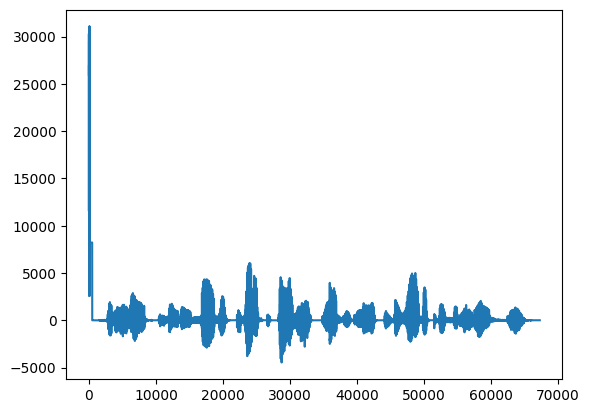

In [11]:
# graph one audio to see start signal that we will remove
import matplotlib.pyplot as plt
plt.plot(train_df['audio'][0])
plt.show()

In [12]:
# Apply the process_row function to each row in the DataFrame
train_df['cropped_audio'] = train_df.apply(crop_audio, axis=1) 
train_df.head()
    

,audio,ipa,phoneme_starts,phoneme_ends,cropped_audio
0,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",hiʃoʊdjuɾimɛnətækbaɪsplɛndidlitɹɹænɪklmiʃins,"[0, 1796, 2308, 3080, 5480, 7880, 9760, 11279,...","[1796, 2308, 3080, 5480, 7880, 9760, 11279, 11...","[3, 1, 4, 12, 12, 8, -1, -6, 0, 4, 6, 11, -1, ..."
1,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",oʊfuɪzmeɪdfɹəmpɹɑsɛstsɔɪbins,"[0, 2150, 3000, 5320, 7740, 10569, 12270, 1340...","[2150, 3000, 5320, 7740, 10569, 12270, 13403, ...","[3, 1, 0, 0, 1, 3, 3, 3, 2, 1, 3, 2, 3, 2, 1, ..."
2,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʃʔihædjɹdɑɹksutiŋɡɹisiwɑʃwɑɾɹʔɔljɪɹ,"[0, 2340, 4320, 5080, 5848, 7018, 9416, 10160,...","[2340, 4320, 5080, 5848, 7018, 9416, 10160, 10...","[3, 5, 3, 3, 1, 2, 3, 2, 2, 2, -1, 2, 1, 2, 0,..."
3,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",tʃɔklɪʔnɹoʊziznɛvɹfeɪləzəɹoʊmæɾikɪft,"[0, 2370, 3442, 5351, 5973, 6863, 7118, 7689, ...","[2370, 3442, 5351, 5973, 6863, 7118, 7689, 887...","[-1, -1, 2, -1, -1, -1, 5, 1, 2, 2, 1, -1, 3, ..."
4,"[25971, 30303, 29285, 26995, 28271, 11552, 131...",ʔɔlmoʊstʔɔlkɑlɪddʒizɹnaʊkoʊɛddʒikeɪʃnl,"[0, 2200, 2661, 3676, 4219, 5175, 6650, 7853, ...","[2200, 2661, 3676, 4219, 5175, 6650, 7853, 831...","[5, 5, 4, 2, 4, 3, 3, 5, 5, 4, 5, 0, 4, 3, 5, ..."


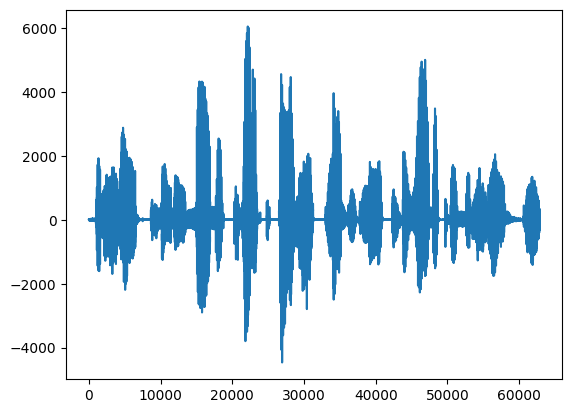

In [13]:
# visualize again, much better!
plt.plot(train_df['cropped_audio'][0])


In [14]:
# train_df comprised of just cropped_audio and phonemes
train_df = train_df.drop(columns=['phoneme_starts', 'phoneme_ends', 'audio'])
# rename cropped audio to audio
train_df = train_df.rename(columns={'cropped_audio': 'audio'})
train_df.head()

,ipa,audio
0,hiʃoʊdjuɾimɛnətækbaɪsplɛndidlitɹɹænɪklmiʃins,"[3, 1, 4, 12, 12, 8, -1, -6, 0, 4, 6, 11, -1, ..."
1,oʊfuɪzmeɪdfɹəmpɹɑsɛstsɔɪbins,"[3, 1, 0, 0, 1, 3, 3, 3, 2, 1, 3, 2, 3, 2, 1, ..."
2,ʃʔihædjɹdɑɹksutiŋɡɹisiwɑʃwɑɾɹʔɔljɪɹ,"[3, 5, 3, 3, 1, 2, 3, 2, 2, 2, -1, 2, 1, 2, 0,..."
3,tʃɔklɪʔnɹoʊziznɛvɹfeɪləzəɹoʊmæɾikɪft,"[-1, -1, 2, -1, -1, -1, 5, 1, 2, 2, 1, -1, 3, ..."
4,ʔɔlmoʊstʔɔlkɑlɪddʒizɹnaʊkoʊɛddʒikeɪʃnl,"[5, 5, 4, 2, 4, 3, 3, 5, 5, 4, 5, 0, 4, 3, 5, ..."


In [24]:
train_ds = Dataset.from_pandas(train_df)

4620

# Extend Phoneme Vocab

In [16]:
timit_vocab = set("".join(train_df['ipa']))
print(timit_vocab)

{'ð', 'f', 'ɹ', 'm', 'e', 'ʔ', 'v', 'ɾ', 'h', 'a', 'w', 'd', 'j', 'ɡ', 'z', 'ə', 'ʌ', 'u', 'θ', 't', 'ɑ', 'ʊ', 'p', 'k', 'l', 'æ', 'b', 'ɛ', 'ɔ', 'ʒ', 's', 'o', 'ŋ', 'ʃ', 'ɪ', 'n', 'i'}


In [17]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_ID)
vocab = tokenizer.get_vocab()
# you will see how large the vocab is, we will resize our linear layer later to make it work for our smaller vocab
print(vocab)

{'A': 267, 'E': 45, 'H': 72, 'I': 20, 'O': 305, 'U': 292, '[PAD]': 310, '[UNK]': 309, '_': 182, 'a': 53, 'ã': 125, 'b': 113, 'b̪': 177, 'b̪͡v': 289, 'b͡ꞵ': 287, 'c': 25, 'cʼ': 229, 'c͡ç': 66, 'd': 176, 'd̼': 118, 'd͡z': 263, 'd͡ð': 244, 'd͡ɮ': 18, 'd͡ʑ': 94, 'd͡ʒ': 280, 'e': 175, 'ẽ': 211, 'e̞': 114, 'ẽ̞': 265, 'f': 139, 'fʼ': 249, 'h': 179, 'i': 245, 'j': 215, 'k': 282, 'kxʼ': 281, 'kǀ': 41, 'kǁ': 61, 'kǂ': 21, 'kǃ': 70, 'kʘ': 79, 'kʼ': 39, 'k̚': 89, 'k͡p': 48, 'k͡x': 198, 'l': 303, 'm': 75, 'm̥': 172, 'n': 102, 'n̥': 28, 'n̼': 169, 'o': 117, 'õ': 119, 'o̞': 62, 'õ̞': 234, 'p': 259, 'pʼ': 286, 'p̚': 149, 'p̪': 273, 'p̪͡f': 105, 'p͡f': 225, 'p͡ɸ': 103, 'q': 130, 'qǀ': 302, 'qǁ': 126, 'qǂ': 299, 'qǃ': 37, 'qʘ': 261, 'qʼ': 58, 'q͡ʡ': 127, 'q͡χʼ': 291, 'q͡ꭓ': 4, 'r': 82, 'r̥': 34, 's': 247, 'sʼ': 200, 't': 307, 'tʼ': 183, 't̚': 241, 't̪͡θʼ': 216, 't̼': 87, 't͡s': 156, 't͡sʼ': 43, 't͡ɕ': 264, 't͡ɬ': 170, 't͡ɬʼ': 164, 't͡ʃ': 91, 't͡ʃʼ': 108, 't͡θ': 140, 'u': 154, 'ũ': 81, 'v': 243, 'w

In [18]:
additional_vocab = timit_vocab.difference(set(vocab.keys()) | {' '})
print("tokens that are in timit but not in the pretrained model", additional_vocab)
tokenizer.add_tokens(list(additional_vocab))

tokens that are in timit but not in the pretrained model set()


0

### Audiomentations 

In [19]:
%pip install audiomentations==0.37.0

Note: you may need to restart the kernel to use updated packages.


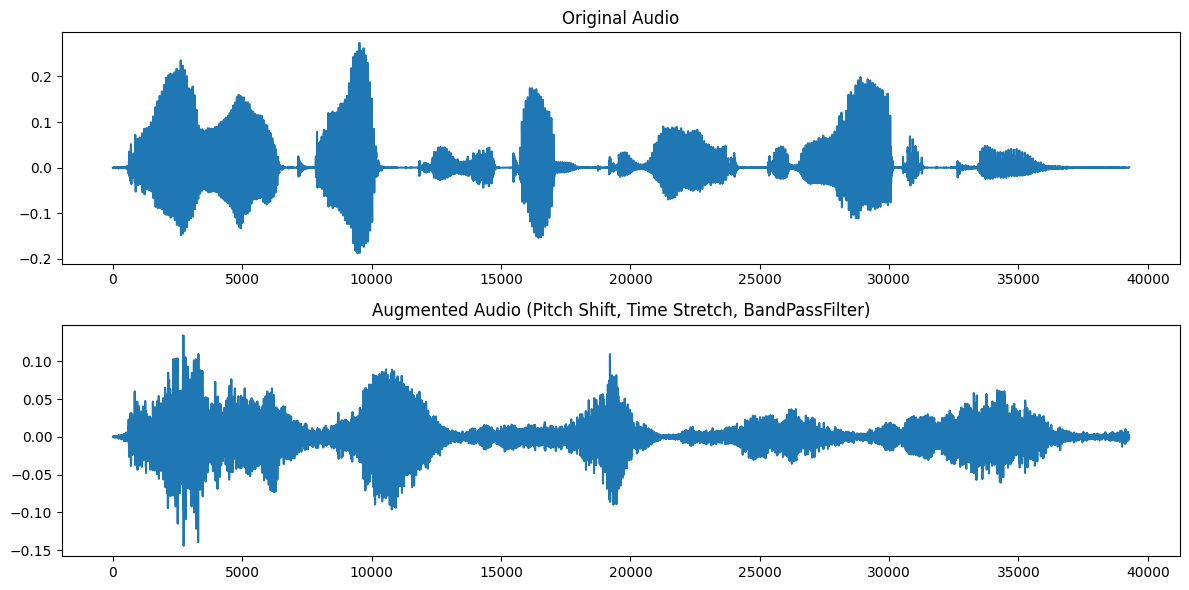


Playing augmented audio:


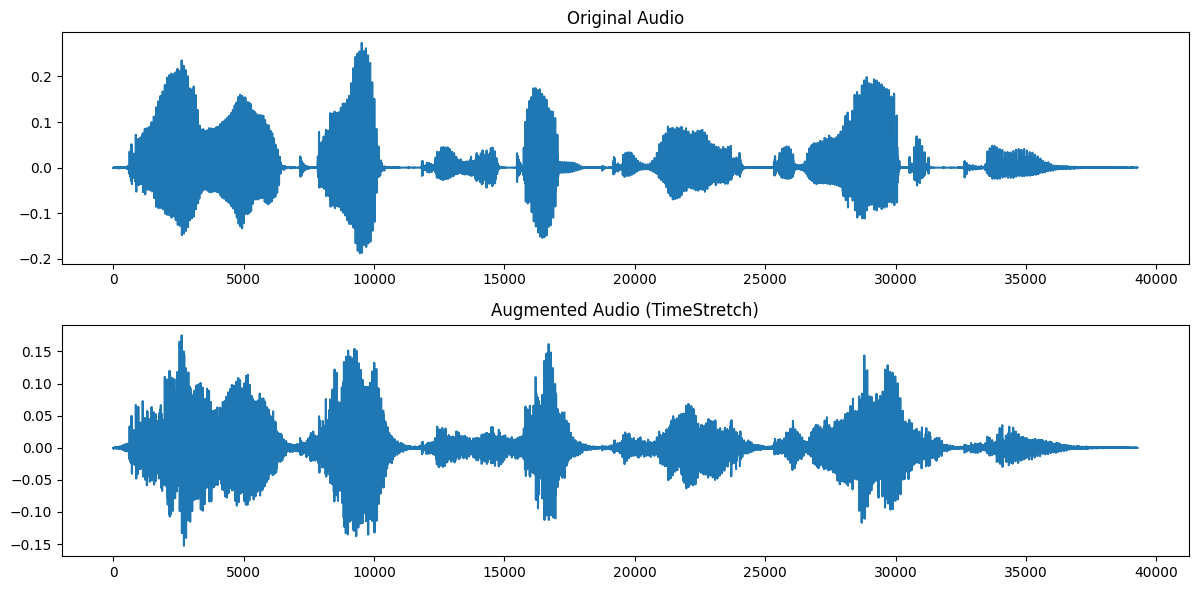


Playing augmented audio:


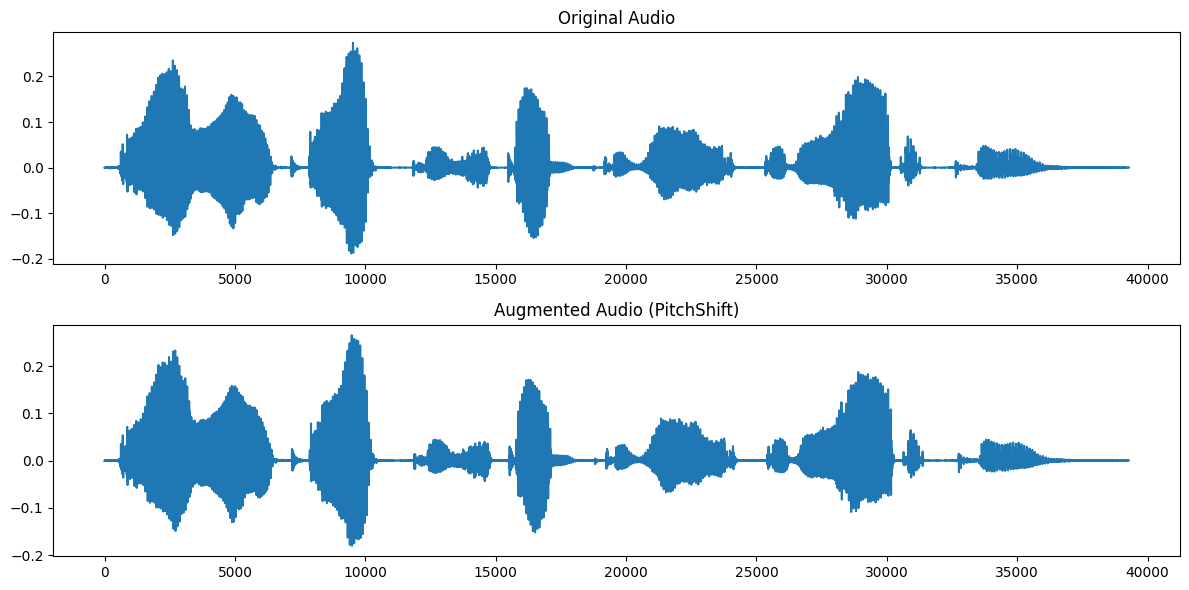


Playing augmented audio:


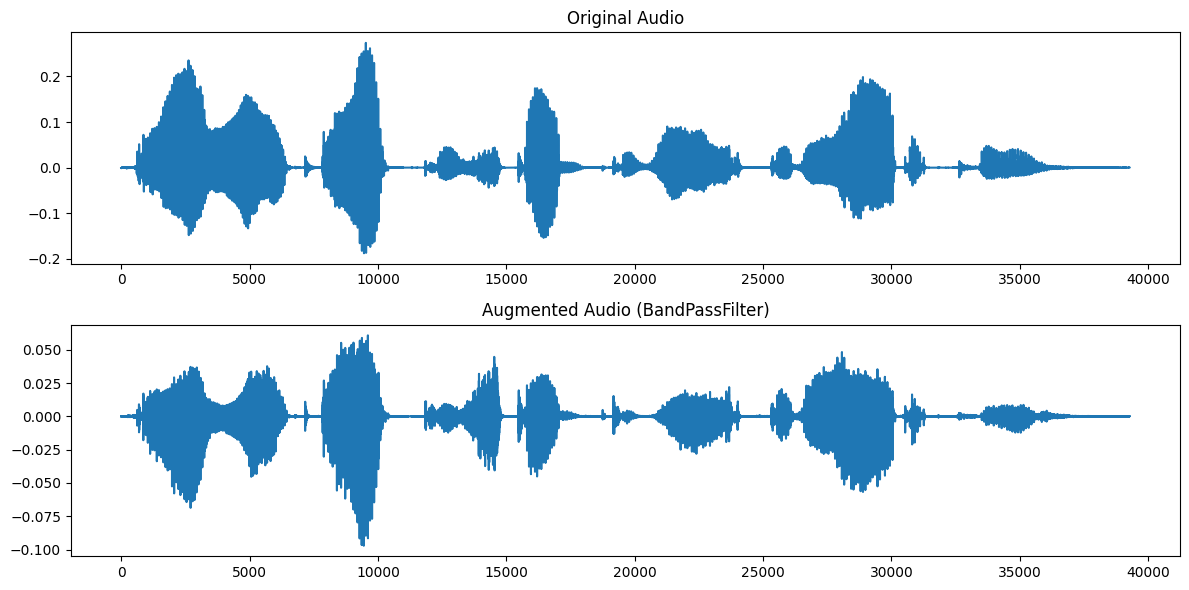


Playing augmented audio:


In [21]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, 
    PitchShift, ApplyImpulseResponse, BandPassFilter
)
import IPython.display as ipd

def plot_and_play_augmentation(samples, augmented_samples, sample_rate, title):
    """Helper function to plot and play audio comparison"""
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.title("Original Audio")
    plt.plot(samples)
    plt.subplot(2, 1, 2)
    plt.title(f"Augmented Audio ({title})")
    plt.plot(augmented_samples)
    plt.tight_layout()
    plt.show()
    
    print("\nPlaying augmented audio:")
    # Play the augmented audio
    ipd.display(ipd.Audio(augmented_samples, rate=sample_rate))

def test_experiments(audio_path):
    """Test all augmentation experiments"""
    # Load audio
    samples, sample_rate = librosa.load(audio_path, sr=16000)
    
    # Experiment 1: Pitch Shift Only
    augment1 = Compose([
        PitchShift(
            min_semitones=-4,
            max_semitones=4,
            p=1.0  # Set to 1.0 for testing
        ),
        TimeStretch(
                min_rate=0.8,
                max_rate=1.00,
                p=1.0
        ),
         BandPassFilter( min_center_freq=100.0, max_center_freq=6000, p=1.0)
    ])
    augmented1 = augment1(samples=samples, sample_rate=sample_rate)

    plot_and_play_augmentation(samples, augmented1, sample_rate, "Pitch Shift, Time Stretch, BandPassFilter")
    
    # Experiment 2: RIR (Note: Requires impulse response files)
    try:
        augment2 = Compose([
            TimeStretch(
                min_rate=0.8,
                max_rate=1.00,
                p=1.0
            )
        ])
        augmented2 = augment2(samples=samples, sample_rate=sample_rate)
        plot_and_play_augmentation(samples, augmented2, sample_rate, "TimeStretch")
    except Exception as e:
        print(f"Skipping RIR test (requires impulse response files): {e}")
    
    # Experiment 3: Combined (Pitch Shift + RIR)
    augment3 = Compose([
        PitchShift(
            min_semitones=-4,
            max_semitones=4,
            p=1.0
        )
    ])
    augmented3 = augment3(samples=samples, sample_rate=sample_rate)
    plot_and_play_augmentation(samples, augmented3, sample_rate, "PitchShift")
    
    # Experiment 4: Full Pipeline
    augment4 = Compose([
        BandPassFilter( min_center_freq=100.0, max_center_freq=6000, p=1.0)
    ])
    augmented4 = augment4(samples=samples, sample_rate=sample_rate)
    plot_and_play_augmentation(samples, augmented4, sample_rate, "BandPassFilter")

# Usage:
if __name__ == "__main__":
    # Replace with your audio path
    audio_path = "/home/arunasri/ML/data/audio_tests/TIMIT_sample_0.wav"
    test_experiments(audio_path)

# Update Feature Extraction

In [21]:
feature_extractor = AutoFeatureExtractor.from_pretrained(PRE_TRAINED_ID)

We don't need to update the feature extractor since it has been pretrained on 16kHz audio which matches the TIMIT dataset.

For datasets with different sampling rates, the feature extractor should be updated or the audio resampled (easier).

This is also where code to add extra features (such as conditioning on speaker's native language etc.) would be added.

# hyperparam search


### Augmentation code

In [22]:
%pip install audiomentations

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import pandas as pd
import torch
from audiomentations import (
    Compose, 
    PitchShift, 
    TimeStretch, 
    BandPassFilter
)

class AudioAugmenter:
    """Handles audio augmentation with different techniques and probabilities"""
    
    def __init__(self):
        # Full augmentation pipeline
        self.full_augment = Compose([
            PitchShift(min_semitones=-4, max_semitones=4, p=1.0),
            TimeStretch(min_rate=0.8, max_rate=1.00, p=1.0),
            BandPassFilter(min_center_freq=100.0, max_center_freq=6000, p=1.0)
        ])
        
        # Individual augmentation techniques
        self.pitch_shift = Compose([
            PitchShift(min_semitones=-4, max_semitones=4, p=1.0)
        ])
        
        self.time_stretch = Compose([
            TimeStretch(min_rate=0.8, max_rate=1.00, p=1.0)
        ])
        
        self.band_pass = Compose([
            BandPassFilter(min_center_freq=100.0, max_center_freq=6000, p=1.0)
        ])
    
    def augment_audio(self, audio, sampling_rate=16000):
        """
        Apply augmentation based on probability distribution:
        - 25% full augmentation
        - 10% pitch shift
        - 10% time stretch
        - 10% band pass filter
        - 45% original
        
        Args:
            audio: audio data (can be list, tensor, or numpy array)
            sampling_rate: audio sampling rate (default: 16000)
            
        Returns:
            augmented audio as numpy array
        """
        # Convert input to numpy array if it isn't already
        if isinstance(audio, (list, tuple)):
            audio = np.array(audio, dtype=np.float32)
        elif isinstance(audio, torch.Tensor):
            audio = audio.numpy().astype(np.float32)
        elif isinstance(audio, np.ndarray):
            audio = audio.astype(np.float32)
        else:
            raise ValueError(f"Unsupported audio type: {type(audio)}")
        
        # Ensure audio is 1D
        if len(audio.shape) > 1:
            audio = audio.squeeze()
        rand_val = np.random.random()
        
        if rand_val < 0.25:  # 25% full augmentation
            return self.full_augment(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.35:  # 10% pitch shift
            return self.pitch_shift(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.45:  # 10% time stretch
            return self.time_stretch(samples=audio, sample_rate=sampling_rate)
        elif rand_val < 0.55:  # 10% band pass
            return self.band_pass(samples=audio, sample_rate=sampling_rate)
        else:  # 45% original
            return audio

def augment_dataset(df, augmenter=None):
    """
    Augment audio data in the dataframe.
    Ensures all audio data is properly converted to float32 numpy arrays.
    """
    if augmenter is None:
        augmenter = AudioAugmenter()
    
    augmented_df = df.copy()
    augmented_df['audio'] = augmented_df['audio'].apply(
        lambda x: augmenter.augment_audio(x)
    )
    
    return augmented_df

## V2 resize finetuning 

In [28]:
import json
import torch
import logging
import tempfile
import wandb 
import numpy as np
from transformers import (
    AutoProcessor, 
    AutoModelForCTC, 
    Trainer, 
    TrainingArguments,
    Wav2Vec2CTCTokenizer,
    EarlyStoppingCallback
)
from datasets import Dataset
from dataclasses import dataclass
from typing import Dict, List, Union
import torchaudio
from sklearn.model_selection import train_test_split
import os
import time
from datetime import datetime
import GPUtil
import psutil

# Constants and logging setup as before
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000
MAX_LABEL_LENGTH = 100

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TrialTimeTracker:
    def __init__(self, output_file):
        self.output_file = output_file
        self.current_trial = None
        self.start_time = None
        
    def start_trial(self, config):
        self.current_trial = {
            'config': config,
            'start_time': datetime.now().isoformat(),
            'gpu_type': self._get_gpu_type(),
            'timestamps': []
        }
        self.start_time = time.time()
        
    def log_timestamp(self, step_name):
        if self.current_trial:
            gpu_metrics = self._get_gpu_metrics()
            timestamp = {
                'step': step_name,
                'elapsed_seconds': time.time() - self.start_time,
                **gpu_metrics
            }
            self.current_trial['timestamps'].append(timestamp)
            logger.info(f"Step {step_name} completed after {timestamp['elapsed_seconds']:.2f}s")
    
    def _get_gpu_type(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return gpu.name
        except:
            return "Unknown"
            
    def _get_gpu_metrics(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return {
                'gpu_utilization': gpu.load * 100,
                'gpu_memory_used': gpu.memoryUsed,
                'gpu_memory_total': gpu.memoryTotal
            }
        except:
            return {
                'gpu_utilization': None,
                'gpu_memory_used': None,
                'gpu_memory_total': None
            }

@dataclass
class DataCollatorCTCWithPadding:
    # Same as before
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )
        padded_inputs = []
        attention_mask = []
        
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            input_values = input_values.squeeze()
            
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

def prepare_model_and_processor(pre_trained_id, timit_vocab, base_dir):
    """Prepare model and processor with vocabulary resizing"""
    logger.info("Loading pretrained model and processor...")
    
    os.makedirs(base_dir, exist_ok=True)
    processor = AutoProcessor.from_pretrained(pre_trained_id)
    model = AutoModelForCTC.from_pretrained(pre_trained_id)
    
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    special_tokens = {
        "[PAD]": 0,
        "<s>": 1,
        "</s>": 2,
        "[UNK]": 3
    }
    
    regular_tokens = sorted(list(timit_vocab - set(['<pad>', '<unk>'])))
    vocab = {**special_tokens}
    
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    logger.info(f"New vocabulary size: {len(vocab)}")
    
    vocab_file = os.path.join(base_dir, "vocab.json")
    with open(vocab_file, 'w') as f:
        json.dump(vocab, f, indent=2)
    
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "[PAD]",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "[UNK]",
    }
    
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    processor.tokenizer = new_tokenizer
    
    # Save processor configuration
    processor_path = os.path.join(base_dir, "processor")
    processor.save_pretrained(processor_path)
    
    # Resize the linear head
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    torch.nn.init.xavier_uniform_(new_layer.weight.data, gain=0.1)
    new_layer.bias.data.uniform_(-0.1, 0.1)
    
    transfer_count = 0
    for token, new_idx in vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
            transfer_count += 1
            
    logger.info(f"Transferred weights for {transfer_count} tokens")
    
    model.lm_head = new_layer
    model.config.vocab_size = len(vocab)
    model.config.pad_token_id = special_tokens["[PAD]"]
    model.config.bos_token_id = special_tokens["<s>"]
    model.config.eos_token_id = special_tokens["</s>"]
    model.config.unk_token_id = special_tokens["[UNK]"]
    
    return model, processor

def prepare_datasets(train_df, processor):
    """Dataset preparation with optimized batch processing"""
    # Same as before
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset

def preprocess_audio(audio_input):
    """Audio preprocessing function"""
    # Same as before
    if isinstance(audio_input, str):
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
    elif isinstance(audio_input, (list, np.ndarray, torch.Tensor)):
        audio_numpy = np.array(audio_input, dtype=np.float32)
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    audio_numpy = audio_numpy.astype(np.float32)
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def run_finetuning(train_df, pre_trained_id, timit_vocab, output_dir):
    """Run finetuning with optimal hyperparameters"""
    tracker = TrialTimeTracker(os.path.join(output_dir, "INTERSPEECH_resize_noiseA_train.jsonl"))
    
    config = {
        "learning_rate": 3.1622776601683795e-05,
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "gradient_accumulation_steps": 2,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "max_grad_norm": 1.0,
        "adam_beta1": 0.9,
        "adam_beta2": 0.975,
        "adam_epsilon": 1e-08
    }
    
    wandb.init(
        project="INTERSPEECH_resize_noiseA_train",
        name="finetuning_optimal_params",
        config=config
    )
    
    tracker.start_trial(config)
    
    tracker.log_timestamp("model_init_start")
    model, processor = prepare_model_and_processor(pre_trained_id, timit_vocab, output_dir)
    model.gradient_checkpointing_enable()
    tracker.log_timestamp("model_init_complete")
    
    tracker.log_timestamp("dataset_prep_start")
    train_dataset, eval_dataset = prepare_datasets(train_df, processor)
    tracker.log_timestamp("dataset_prep_complete")
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        **config,
        num_train_epochs=20,
        logging_steps=50,
        save_steps=100,
        eval_steps=100,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_strategy="steps",
        save_total_limit=2,
        fp16=True,
        dataloader_num_workers=16,
        gradient_checkpointing=True,
        dataloader_prefetch_factor=4,
        ddp_find_unused_parameters=False
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorCTCWithPadding(processor=processor, padding="longest"),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )
    
    tracker.log_timestamp("training_start")
    train_result = trainer.train()
    tracker.log_timestamp("training_complete")
    
    eval_result = trainer.evaluate()
    tracker.log_timestamp("evaluation_complete")
    
    logger.info("Saving final model and processor...")
    trainer.save_model(os.path.join(output_dir, "final_model"))
    processor.save_pretrained(os.path.join(output_dir, "final_processor"))
    
    wandb.finish()

if __name__ == "__main__":  
    # Create augmenter and augment dataset
    augmenter = AudioAugmenter()
    augmented_df = augment_dataset(train_df, augmenter)
    
    # Run systematic search with augmented dataset
    results_file = run_finetuning(
        train_df=augmented_df,
        pre_trained_id=PRE_TRAINED_ID,  # Replace with your pretrained model ID
        timit_vocab=timit_vocab,  # Replace with your TIMIT vocabulary set
        output_dir="INTERSPEECH_resize_noiseA_train.jsonl"
    )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aruna-sri (aruna-team). Use `wandb login --relogin` to force relogin


INFO:__main__:Step model_init_start completed after 0.12s
INFO:__main__:Loading pretrained model and processor...
INFO:__main__:Initial vocabulary size: 313
INFO:__main__:New vocabulary size: 41
INFO:__main__:Transferred weights for 41 tokens
INFO:__main__:Step model_init_complete completed after 1.66s
INFO:__main__:Step dataset_prep_start completed after 1.77s
INFO:__main__:Splitting dataset into train and evaluation...
Map (num_proc=4):   0%|          | 0/3696 [00:00<?, ? examples/s]/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Map (num_proc=4):   4%|▎         | 136/3696 [00:09<04:00, 14.82 examples/s]/home/arunasri/ML/venv/lib/python3.8/site-packages/transfo

Step,Training Loss,Validation Loss
100,5.410400,2.483152
200,4.477700,1.920467
300,3.742300,1.664098
400,3.309400,1.477049
500,2.942800,1.342977
600,3.024100,1.254912
700,2.683700,1.188691
800,2.736300,1.131267
900,2.547700,1.064277
1000,2.393700,1.053429


/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/arunasri/ML/venv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argum

INFO:__main__:Step evaluation_complete completed after 4529.93s
INFO:__main__:Saving final model and processor...


eval/loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▃█▅▅▄▄▄▄▅▄▅▄▅▅▄█▄▄▄▄▄▆▄
eval/samples_per_second,▇█▇███▇██████▇▇▇▆▆▆▄▂▄▂▃▃▂▂▃▂▃▂▃▂▃▄▄▃▂▁▃
eval/steps_per_second,▇██▇████████▇█▇▆▆▅▄▁▄▃▄▄▄▄▃▄▄▃▃▄▁▄▄▄▄▄▃▃
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
train/global_step,▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/grad_norm,▆▃▃▁▂▂▂▂▃▂▄▄▂▂▃▃▂█▂▂▁▃▁▁▂▃▂▂▂▃▃▂▂▄▁▂▄▃▂▁
train/learning_rate,▁▂▂▅▆▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃
train/loss,█▆▆▆▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
eval/loss,0.7117
eval/runtime,24.8898


## Save Model on Hugging Face

In [2]:
from transformers import AutoModelForCTC, Wav2Vec2Processor
from huggingface_hub import login

# Log in to Hugging Face (if not already logged in)
login("your-token")

# Load the model and processor from your local directory
model = AutoModelForCTC.from_pretrained("/home/arunasri/ML/notebooks/results/INTERSPEECH_no_resize_noiseA_train/final_model")
processor = Wav2Vec2Processor.from_pretrained("/home/arunasri/ML/notebooks/results/INTERSPEECH_no_resize_noiseA_train/final_model")

# Specify the directory where you want to save the model
save_directory = "./xlsr-timit-c1"

# Save and upload to Hugging Face Model Hub under an organization
model.save_pretrained(save_directory, push_to_hub=True, repo_id="KoelLabs/xlsr-timit-c1")
processor.save_pretrained(save_directory)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/arunasri/.cache/huggingface/token
Login successful


model.safetensors: 100%|██████████| 1.26G/1.26G [00:23<00:00, 54.1MB/s]


[]

# Instructions to Upload Model to Hugging Face

1. **Login to Hugging Face**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli login


2. **Create a Repository**  
   Run the following command to log in to your Hugging Face account:
   ```bash
   huggingface-cli repo create your-model-name --organization your-org-name

3. **Git clone**  
   Run the following command to clone your repo:
   ```bash 
   git clone https://huggingface.co/your-org-name/your-model-name

4. **Upload Model**  (if you did not make it on Hugging Face already)
   Run the following command to clone your repo:
   ```bash 
   huggingface-cli repo upload --path ./<path here>


5. **Move Other Files**  
   Run the following command to copy each file into the repo:
   ```bash
   cp -r ./<path here> <your-cloned-repo-folder> 

6. **Stage & Commit!**
    Run the following git commands
    ```bash
    git add README.md
    git commit -m "Add model card"
    git push


### YAAAAY CONGRATULATIONS 

In [ ]:
%pip install optuna joblib
# you can use WADNB sweeps as well, whatever is easier

## Noise Hyperparam search

In [ ]:

import json
import torch
import logging
import tempfile
import wandb
import numpy as np
from transformers import (
    AutoProcessor, 
    AutoModelForCTC, 
    Trainer, 
    TrainingArguments, 
    Wav2Vec2CTCTokenizer,
    EarlyStoppingCallback,
    TrainerCallback
)
from datasets import Dataset
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torchaudio
from sklearn.model_selection import train_test_split
from itertools import product
from datetime import datetime
import time
import GPUtil
import psutil

class TrialTimeTracker:
    """Track detailed timing information for each trial"""
    def __init__(self, output_file):
        self.output_file = output_file
        self.current_trial = None
        self.start_time = None
        
    def start_trial(self, trial_config, trial_id):
        self.current_trial = {
            'trial_id': trial_id,
            'config': trial_config,
            'start_time': datetime.now().isoformat(),
            'gpu_type': self._get_gpu_type(),
            'timestamps': []
        }
        self.start_time = time.time()
        
    def log_timestamp(self, step_name):
        if self.current_trial:
            gpu_metrics = self._get_gpu_metrics()
            timestamp = {
                'step': step_name,
                'elapsed_seconds': time.time() - self.start_time,
                **gpu_metrics
            }
            self.current_trial['timestamps'].append(timestamp)
            logger.info(f"Step {step_name} completed after {timestamp['elapsed_seconds']:.2f}s")
            
    def end_trial(self, eval_loss=None):
        if self.current_trial:
            self.current_trial['total_time'] = time.time() - self.start_time
            if eval_loss is not None:
                self.current_trial['eval_loss'] = eval_loss
            
            with open(self.output_file, 'a') as f:
                json.dump(self.current_trial, f)
                f.write('\n')
            
            trial_summary = self.current_trial.copy()
            self.current_trial = None
            return trial_summary
    
    def _get_gpu_type(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return gpu.name
        except:
            return "Unknown"
            
    def _get_gpu_metrics(self):
        try:
            gpu = GPUtil.getGPUs()[0]
            return {
                'gpu_utilization': gpu.load * 100,
                'gpu_memory_used': gpu.memoryUsed,
                'gpu_memory_total': gpu.memoryTotal
            }
        except:
            return {
                'gpu_utilization': None,
                'gpu_memory_used': None,
                'gpu_memory_total': None
            }

# Constants
SAMPLING_RATE = 16000
MAX_AUDIO_LENGTH = 160000  # 10 seconds at 16kHz
MAX_LABEL_LENGTH = 100

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    """
    processor: AutoProcessor
    padding: Union[bool, str] = "longest"

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        max_length = min(
            max(len(feature["input_values"]) for feature in features),
            MAX_AUDIO_LENGTH
        )
        padded_inputs = []
        attention_mask = []
        for feature in features:
            input_length = len(feature["input_values"])
            padding_length = max_length - input_length
            
            if isinstance(feature["input_values"], list):
                input_values = torch.tensor(feature["input_values"])
            else:
                input_values = feature["input_values"]
            
            input_values = input_values.squeeze()
            
            if padding_length > 0:
                padded_input = torch.nn.functional.pad(input_values, (0, padding_length))
                attention_mask.append(torch.cat([torch.ones(input_length), torch.zeros(padding_length)]))
            else:
                padded_input = input_values
                attention_mask.append(torch.ones(input_length))
            
            padded_inputs.append(padded_input)

        batch = {
            "input_values": torch.stack(padded_inputs),
            "attention_mask": torch.stack(attention_mask)
        }

        with self.processor.as_target_processor():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

def prepare_datasets(train_df, processor):
    """
    Dataset preparation with optimized batch processing
    """
    logger.info("Splitting dataset into train and evaluation...")
    
    train_data, eval_data = train_test_split(train_df, test_size=0.2, random_state=42)
    
    def process_data(batch):
        # Preprocess audio
        audio = preprocess_audio(batch["audio"])
        audio = audio.squeeze()
        
        # Process audio without padding or tensor conversion
        inputs = processor(
            audio, 
            sampling_rate=SAMPLING_RATE, 
            return_tensors=None
        )
        
        input_values = np.squeeze(inputs["input_values"])
        
        # Process labels
        with processor.as_target_processor():
            labels = processor(batch["ipa"]).input_ids
        
        return {
            "input_values": input_values,
            "labels": labels,
            "audio": audio
        }
    
    # Convert DataFrames to Datasets with optimized batch processing
    train_dataset = Dataset.from_pandas(train_data)
    eval_dataset = Dataset.from_pandas(eval_data)
    
    # Apply processing with larger batches
    train_dataset = train_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in train_dataset.column_names if col != "audio"]
    )
    eval_dataset = eval_dataset.map(
        process_data,
        batch_size=32,
        num_proc=4,
        remove_columns=[col for col in eval_dataset.column_names if col != "audio"]
    )
    
    return train_dataset, eval_dataset

def preprocess_audio(audio_input):
    """
    Load and preprocess audio to match expected format.
    """
    # Handle different input types
    if isinstance(audio_input, str):  # File path
        waveform, sample_rate = torchaudio.load(audio_input)
        audio_numpy = waveform.squeeze().numpy()
        
    elif isinstance(audio_input, list):  # List input
        audio_numpy = np.array(audio_input, dtype=np.float32)
        
    elif isinstance(audio_input, np.ndarray):  # Already numpy array
        audio_numpy = audio_input
        
    elif isinstance(audio_input, torch.Tensor):  # Torch tensor
        audio_numpy = audio_input.numpy()
        
    else:
        raise ValueError(f"Unsupported audio type: {type(audio_input)}")
    
    # Ensure float32 dtype
    audio_numpy = audio_numpy.astype(np.float32)
    
    # Ensure 1D array
    if len(audio_numpy.shape) > 1:
        audio_numpy = np.mean(audio_numpy, axis=0)
    
    # Normalize audio
    if np.abs(audio_numpy).max() > 1:
        audio_numpy = audio_numpy / np.abs(audio_numpy).max()
    
    # Trim or pad to max length
    if len(audio_numpy) > MAX_AUDIO_LENGTH:
        audio_numpy = audio_numpy[:MAX_AUDIO_LENGTH]
    elif len(audio_numpy) < MAX_AUDIO_LENGTH:
        padding = np.zeros(MAX_AUDIO_LENGTH - len(audio_numpy), dtype=np.float32)
        audio_numpy = np.concatenate([audio_numpy, padding])
    
    return audio_numpy

def prepare_model_and_processor(pre_trained_id, timit_vocab):
    """
    Prepare the model and processor with reduced vocabulary and resized linear head.
    """
    logger.info("Loading pretrained model and processor...")
    
    # Create base directory
    base_dir = "/home/arunasri/ML/notebooks/results/a100_resize_structured_v4"
    os.makedirs(base_dir, exist_ok=True)
    
    processor = AutoProcessor.from_pretrained(pre_trained_id)
    model = AutoModelForCTC.from_pretrained(pre_trained_id)
    
    # Log initial vocabulary details
    old_vocab = processor.tokenizer.get_vocab()
    logger.info(f"Initial vocabulary size: {len(old_vocab)}")
    
    # Define special tokens with fixed positions matching pretrained model
    special_tokens = {
        "[PAD]": 0,
        "<s>": 1,
        "</s>": 2,
        "[UNK]": 3
    }
    
    # Create new vocabulary
    regular_tokens = sorted(list(timit_vocab - set(['<pad>', '<unk>'])))  # Remove old-style tokens if present
    vocab = {**special_tokens}
    
    for idx, token in enumerate(regular_tokens):
        vocab[token] = idx + len(special_tokens)
    
    logger.info(f"New vocabulary size: {len(vocab)}")
    
    # Save vocabulary for inspection
    vocab_file = os.path.join(base_dir, "vocab.json")
    with open(vocab_file, 'w') as f:
        json.dump(vocab, f, indent=2)
    
    # Create new tokenizer with matching special tokens
    tokenizer_config = {
        "vocab": vocab,
        "pad_token": "[PAD]",
        "bos_token": "<s>",
        "eos_token": "</s>",
        "unk_token": "[UNK]",
    }
    
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        json.dump(vocab, f)
        vocab_path = f.name
    
    new_tokenizer = Wav2Vec2CTCTokenizer(
        vocab_path,
        **{k: v for k, v in tokenizer_config.items() if k != "vocab"}
    )
    
    processor.tokenizer = new_tokenizer
    
    # Save processor configuration
    processor_path = os.path.join(base_dir, "processor")
    processor.save_pretrained(processor_path)
    logger.info(f"Saved processor configuration to {processor_path}")
    
    # Resize the linear head
    old_weights = model.lm_head.weight.data
    old_bias = model.lm_head.bias.data
    
    new_layer = torch.nn.Linear(model.lm_head.in_features, len(processor.tokenizer))
    torch.nn.init.xavier_uniform_(new_layer.weight.data, gain=0.1)
    new_layer.bias.data.uniform_(-0.1, 0.1)
    
    # Transfer weights for matching tokens
    transfer_count = 0
    for token, new_idx in vocab.items():
        if token in old_vocab:
            old_idx = old_vocab[token]
            new_layer.weight.data[new_idx, :] = old_weights[old_idx, :]
            new_layer.bias.data[new_idx] = old_bias[old_idx]
            transfer_count += 1
            logger.info(f"Transferred token '{token}' from position {old_idx} to {new_idx}")
    
    logger.info(f"Transferred weights for {transfer_count} tokens")
    
    # Update model configuration
    model.lm_head = new_layer
    model.config.vocab_size = len(vocab)
    model.config.pad_token_id = special_tokens["[PAD]"]
    model.config.bos_token_id = special_tokens["<s>"]
    model.config.eos_token_id = special_tokens["</s>"]
    model.config.unk_token_id = special_tokens["[UNK]"]
    
    return model, processor

def generate_systematic_configs():
    """Generate systematic hyperparameter configurations"""
    learning_rates = np.logspace(-6, -4, num=5)
    batch_sizes = [4, 8, 16]
    grad_accums = [2, 4, 8]
    warmup_ratios = [0.05, 0.1, 0.15]
    weight_decays = np.logspace(-3, -1, num=3)
    max_grad_norms = [0.5, 1.0, 2.0]
    adam_beta1s = [0.85, 0.9, 0.95]
    adam_beta2s = [0.95, 0.975, 0.999]
    adam_epsilons = np.logspace(-9, -7, num=3)
    
    primary_configs = list(product(
        learning_rates,
        batch_sizes,
        grad_accums
    ))
    
    secondary_params = {
        'warmup_ratio': warmup_ratios[1],
        'weight_decay': weight_decays[1],
        'max_grad_norm': max_grad_norms[1],
        'adam_beta1': adam_beta1s[1],
        'adam_beta2': adam_beta2s[1],
        'adam_epsilon': adam_epsilons[1]
    }
    
    configs = []
    for lr, bs, ga in primary_configs:
        config = {
            'learning_rate': float(lr),
            'per_device_train_batch_size': bs,
            'per_device_eval_batch_size': bs,
            'gradient_accumulation_steps': ga,
            **secondary_params
        }
        configs.append(config)
    
    return configs
class LossMonitorCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                current_loss = logs['loss']
                if current_loss > 10.0:
                    logger.warning(f"High loss detected: {current_loss}")
                    logger.warning("This may indicate issues with vocabulary handling or model configuration")
                elif current_loss < 0.1:
                    logger.warning(f"Unusually low loss detected: {current_loss}")
                    logger.warning("This may indicate potential issues with loss computation")

def run_systematic_search(train_df, pre_trained_id, timit_vocab, resume_file="INTERSPEECH_resize_noiseA.jsonl", start_trial=0):
    """Run systematic hyperparameter search with enhanced monitoring"""
    configs = generate_systematic_configs()
    logger.info(f"Generated {len(configs)} configurations for systematic search")
    logger.info(f"Starting from trial {start_trial}")
    
    # Initialize tracking file - but only truncate if starting from beginning
    if start_trial == 0:
        tracker = TrialTimeTracker(output_file=resume_file)
        logger.info(f"Starting fresh search with results saved to {resume_file}")
    else:
        # Append mode for resuming
        tracker = TrialTimeTracker(output_file=resume_file)
        logger.info(f"Resuming search from trial {start_trial}, appending to {resume_file}")
    
    # Skip trials before start_trial
    for trial_idx, config in enumerate(configs[start_trial:], start=start_trial):
        logger.info(f"\nStarting trial {trial_idx + 1}/{len(configs)}")
        logger.info(f"Configuration: {json.dumps(config, indent=2)}")
        
        run_name = f"trial_{trial_idx}_resize_v4"
        wandb.init(
            project="INTERSPEECH_Resize_noiseA",
            name=run_name,
            config=config,
            reinit=True
        )
        
        try:
            tracker.start_trial(config, trial_idx)
            
            # Initialize model and processor with validation
            tracker.log_timestamp("model_init_start")
            model, processor = prepare_model_and_processor(pre_trained_id, timit_vocab)
            model.gradient_checkpointing_enable()
            tracker.log_timestamp("model_init_complete")
            
            # Prepare datasets
            tracker.log_timestamp("dataset_prep_start")
            train_dataset, eval_dataset = prepare_datasets(train_df, processor)
            tracker.log_timestamp("dataset_prep_complete")
            
            # Training setup
            output_dir = f"./results/INTERSPEECH_Resize_noiseA/trial_{trial_idx}"
            training_args = TrainingArguments(
                output_dir=output_dir,
                **config,
                num_train_epochs=5,
                logging_steps=50,
                save_steps=100,
                eval_steps=100,
                evaluation_strategy="steps",
                load_best_model_at_end=True,
                metric_for_best_model="eval_loss",
                greater_is_better=False,
                save_strategy="steps",
                save_total_limit=2,
                fp16=True,
                dataloader_num_workers=16,
                gradient_checkpointing=True,
                dataloader_prefetch_factor=4,
                ddp_find_unused_parameters=False,
                resume_from_checkpoint=True
            )
            
            # Initialize trainer with callbacks
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                data_collator=DataCollatorCTCWithPadding(processor=processor, padding="longest"),
                callbacks=[
                    EarlyStoppingCallback(early_stopping_patience=5),
                    LossMonitorCallback()
                ]
            )
            
            # Training
            tracker.log_timestamp("training_start")
            train_result = trainer.train()
            tracker.log_timestamp("training_complete")
            
            # Evaluation
            eval_result = trainer.evaluate()
            tracker.log_timestamp("evaluation_complete")
            
            # Log results
            wandb.log({
                "eval_loss": eval_result["eval_loss"],
                "train_loss": train_result.training_loss,
                "total_training_time": train_result.metrics["train_runtime"],
                "samples_per_second": train_result.metrics["train_samples_per_second"]
            })
            
            tracker.end_trial(eval_loss=eval_result["eval_loss"])
            
        except Exception as e:
            logger.error(f"Error in trial {trial_idx}: {str(e)}")
            tracker.end_trial()
        
        finally:
            wandb.finish()
    
    return resume_file

if __name__ == "__main__":  
    # Create augmenter and augment dataset
    augmenter = AudioAugmenter()
    augmented_df = augment_dataset(train_df, augmenter)
    
    # Run systematic search with augmented dataset
    results_file = run_systematic_search(
        train_df=augmented_df,
        pre_trained_id=PRE_TRAINED_ID,  # Replace with your pretrained model ID
        timit_vocab=timit_vocab,  # Replace with your TIMIT vocabulary set
        resume_file="INTERSPEECH_resize_noiseA.jsonl", 
        start_trial=23
    )